# Interpolation and Resampling
In an ideal world we would have the same number of observation for each variable, sampled at the same frequency, but as we saw on the last section this is not the case. 
Naturally we have two options 
- Reduce the sampling frequency by mean of `resampling`
- Increase the sampling frequency by means of `interpolate`  


## Resampling
:::{card} Exercise 1
Read the `resample` method [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html). For the temperature data,  compare the original data (daily observations) with the data resampled to 3 days, 5 days, a week and a month.
:::

In [1]:
from funciones import*
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
from importlib import reload

# Data=pd.read_csv("../../Data/Time_series_DATA.txt",skiprows=149,index_col=0)
file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/develop_1/data/Time_series_DATA.txt')
Data=pd.read_csv(file3,skiprows=149,index_col=0)
Data.index = Data.index.astype(str).str.split().str[0]
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[(Data.index.year >= 1915) & (Data.index.year < 2024)]
Data=Data.drop(columns=['Days since start of year','Predicted ice thickness [m]','Noisy predicted ice thickness [m]'])


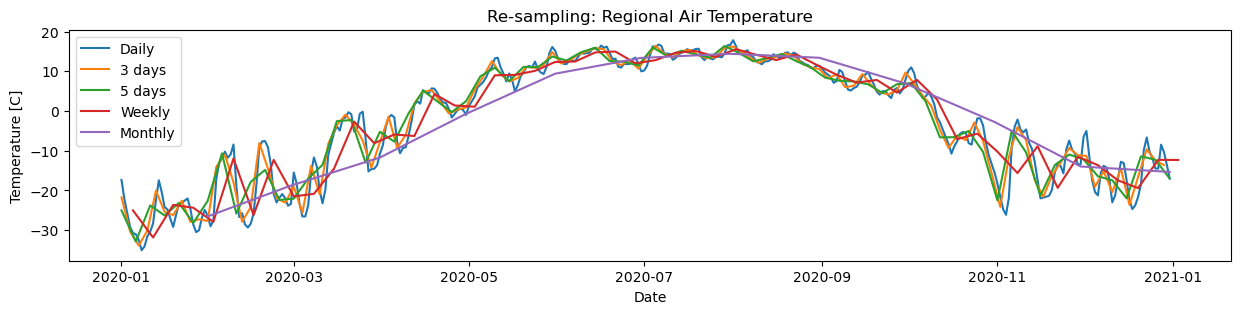

In [2]:
Temperature=Data['Regional: Air temperature [C]'] 
Temperature= Temperature[(Temperature.index.year >= 2020) & (Temperature.index.year < 2021)]
Temp_w3=Temperature.resample('3D').mean()
Temp_w5=Temperature.resample('5D').mean()
Temp_w7=Temperature.resample('W').mean()
Temp_w30=Temperature.resample('ME').mean()

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Regional Air Temperature')
plt.plot(Temperature, label='Daily')
plt.plot(Temp_w3,label='3 days')
plt.plot(Temp_w5,label='5 days')
plt.plot(Temp_w7,label='Weekly')
plt.plot(Temp_w30,label='Monthly')
plt.ylabel("Temperature [C]")
plt.xlabel("Date")
plt.legend()

We used the method `resample().mean`, but we can pass other potentially useful argument such as `.max`,`std`, `sum`, etc.
> connection to de-clustering time in EVA

For example, the rainfall data has daily observation but we might care about the precipitation of the total storm event that may last more than one day. 

::: {card} Exercise 2
Resample the rainfall observation using the `.sum` method
:::

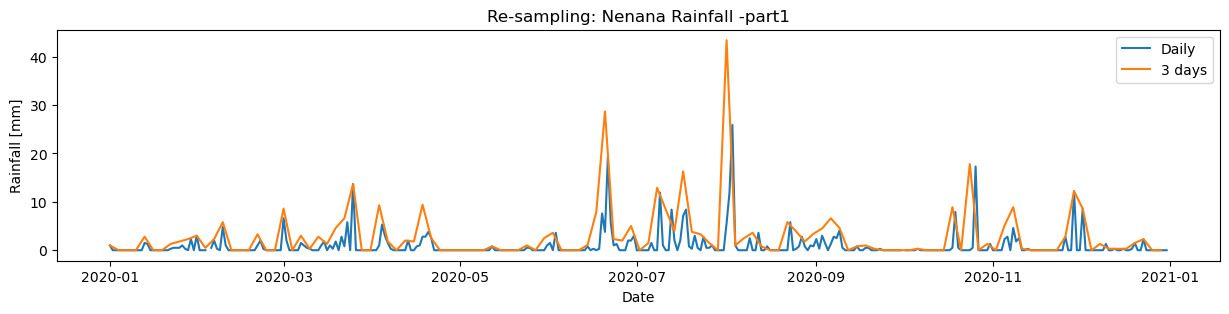

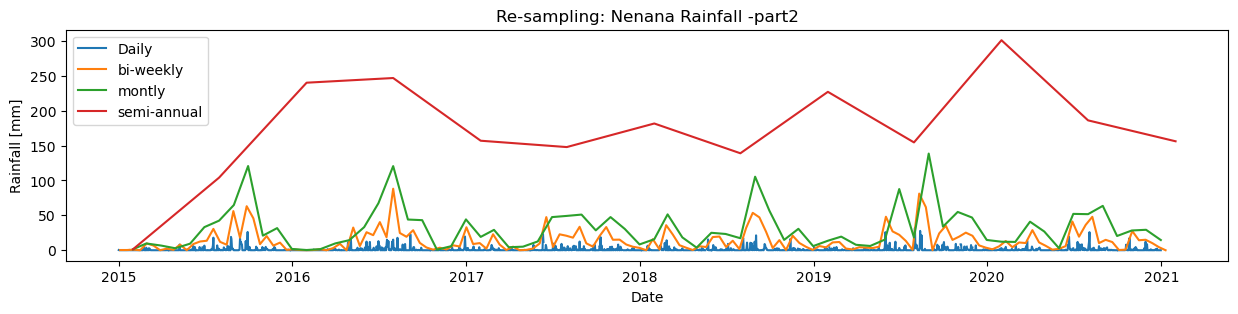

In [3]:
Rain=Data['Nenana: Rainfall [mm]'] 
Rain= Rain[(Rain.index.year >= 2020) & (Rain.index.year < 2021)]
Rain_d3=Rain.resample('3D').sum()
Rain_d5=Rain.resample('5D').sum()
Rain_d7=Rain.resample('7D').sum()
Rain_d30=Rain.resample('ME').sum()

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Nenana Rainfall -part1')
plt.plot(Rain, label='Daily')
plt.plot(Rain_d3,label='3 days')
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
plt.legend()
plt.show()


Rain=Data['Nenana: Rainfall [mm]'] 
Rain= Rain[(Rain.index.year >= 2015) & (Rain.index.year < 2021)]
Rain_d3=Rain.resample('3D').sum()
Rain_d15=Rain.resample('2W').sum()
Rain_d30=Rain.resample('ME').sum()
Rain_d365=Rain.resample('6ME').sum()

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Nenana Rainfall -part2')
plt.plot(Rain, label='Daily')
plt.plot(Rain_d15,label='bi-weekly')
plt.plot(Rain_d30,label='montly')
plt.plot(Rain_d365,label='semi-annual')
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
plt.legend()
plt.show()





## Interpolating
Interpolation in dataframes work a little bit different than in other languages, for example in `Matlab` we provide the *y_vector* , the *x_vector* and the *new_x_vector* such that by controlling the content of *new_x_vector* we can adjust the amount and location of the interpolated points. In dataframes, the location of the points is determined by the index of the original df.

::: {card} Exercise 3

Use the `interpolate` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) to add daily observations to `Data['IceThickness [cm]' ]`
:::


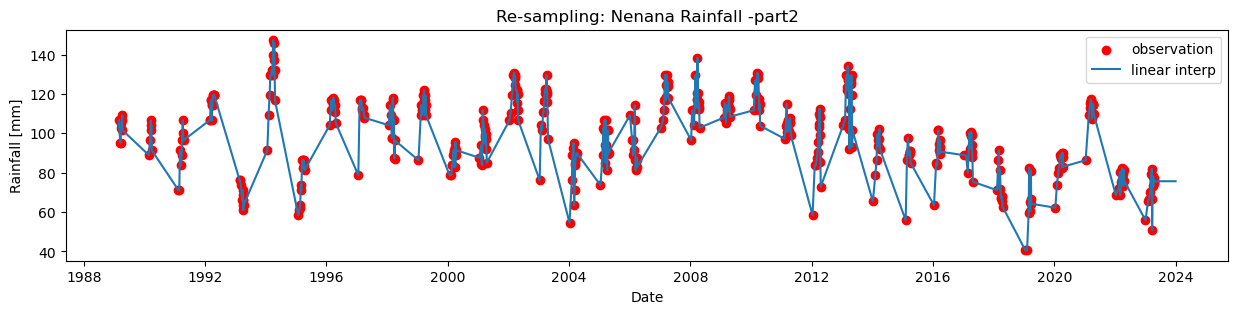

In [4]:
ICE_linear=Data['IceThickness [cm]'].interpolate(method='linear')

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Nenana Rainfall -part2')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_linear, label='linear interp')
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
plt.legend()
plt.show()